 The main goal of this analysis is to study financial inclusion trends in Kenya using the 2016 and 2021 datasets.
 We aim to compare financial service usage, identify key factors influencing inclusion/exclusion, and prepare data for predictive modeling.
Key metrics to track include the percentage of the population with a bank account, mobile money account,

[NOTEBOOK TO DATASELECTION](https://drive.google.com/file/d/1hfD2-nWrU77CfZ4w_gBvmuwnWms7l4Xs/view?usp=sharing)

In [5]:
#!pip install lime


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import lime
import lime.lime_tabular



import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)




In [7]:

# Load your data
df_2021 = pd.read_csv("https://raw.githubusercontent.com/Keltings/Data/refs/heads/main/selected_2021_data.csv")
df_2016 = pd.read_csv("https://raw.githubusercontent.com/Keltings/Data/refs/heads/main/selected_2016_data.csv")

# Drop ID
df_2021.drop(columns=["respondent_id"], inplace=True)
df_2016.drop(columns=["respondent_id"], inplace=True)

#

In [8]:

feature_groups = {
    'formal_savings': [
        'bank_account_current', 'bank_account_savings', 'bank_account_everyday',
        'postbank_account', 'savings_microfinance', 'savings_sacco'
    ],
    'informal_savings': [
        'savings_group_friends', 'savings_family_friend', 'savings_secret_place'
    ],
    'digital_financial': [
        'mobile_money_registered', 'mobile_banking_registered', 'savings_mobile_banking',
        'loan_mobile_banking', 'loan_digital_app'
    ],
    'formal_credit': [
        'loan_bank', 'loan_sacco', 'loan_microfinance', 'loan_govt',
        'loan_employer', 'loan_mortgage'
    ],
    'informal_credit': [
        'loan_shylock', 'loan_group_chama', 'loan_family_friend',
        'loan_shopkeeper_cash', 'loan_goods_credit'
    ],
    'insurance': [
        'insurance_motor', 'insurance_home', 'insurance_crop', 'insurance_livestock',
        'insurance_nhif', 'insurance_health_other', 'insurance_life', 'insurance_education',
        'insurance_other'
    ],
    'pension': [
        'pension_nssf', 'pension_mbao', 'pension_other'
    ]
}

def binary_encode(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            if set(df[col].unique()).issubset({'Yes', 'No', 'yes', 'no', ' ', '', None, np.nan}):
                df[col] = df[col].map({
                    'Yes': 1, 'yes': 1,
                    'No': 0, 'no': 0,
                    ' ': 0, '': 0,
                    None: 0, np.nan: 0
                })
    return df.fillna(0)



In [9]:
def create_behavioral_features(df):
    df = binary_encode(df)

    for group_name, features in feature_groups.items():
        valid_features = [f for f in features if f in df.columns]
        df[f'{group_name}_score'] = df[valid_features].sum(axis=1)

    # Financial Product Diversity (Total product usage)
    all_features = [f for group in feature_groups.values() for f in group if f in df.columns]
    df['financial_product_diversity'] = df[all_features].sum(axis=1)

    # Formal Financial Services Score
    formal_features = feature_groups['formal_savings'] + feature_groups['formal_credit'] + \
                      feature_groups['insurance'] + feature_groups['pension']
    valid_formal = [f for f in formal_features if f in df.columns]
    df['formal_financial_score'] = df[valid_formal].sum(axis=1)

    # Informal Financial Services Score
    informal_features = feature_groups['informal_savings'] + feature_groups['informal_credit']
    valid_informal = [f for f in informal_features if f in df.columns]
    df['informal_financial_score'] = df[valid_informal].sum(axis=1)

    # Digital Financial Score (already calculated)
    # Formal vs Informal Usage Category
    df['formal_informal_ratio'] = np.where(
        df['informal_financial_score'] == 0,
        np.where(df['formal_financial_score'] > 0, 'Formal_Only', 'None'),
        np.where(df['formal_financial_score'] == 0, 'Informal_Only', 'Mixed')
    )

    # Financial Engagement Score (Weighted)
    df['financial_engagement_score'] = (
        1.5 * df['formal_financial_score'] +
        1.0 * df['informal_financial_score'] +
        2.0 * df['digital_financial_score']
    )

    # Product Category Diversity
    category_usage = [(df[f'{group}_score'] > 0).astype(int) for group in feature_groups]
    df['product_category_diversity'] = sum(category_usage)

    # Financial Risk Management (Insurance + Pension)
    risk_features = feature_groups['insurance'] + feature_groups['pension']
    valid_risk = [f for f in risk_features if f in df.columns]
    df['risk_management_score'] = df[valid_risk].sum(axis=1)

    # Credit to Savings Usage Category
    total_savings = df['formal_savings_score'] + df['informal_savings_score']
    total_credit = df['formal_credit_score'] + df['informal_credit_score']

    df['credit_to_savings_ratio'] = np.where(
        total_savings == 0,
        np.where(total_credit > 0, 'Credit_Only', 'None'),
        np.where(total_credit == 0, 'Savings_Only', 'Mixed')
    )

    return df


In [10]:
df_2016_processed = create_behavioral_features(df_2016.copy())
df_2021_processed = create_behavioral_features(df_2021.copy())


In [11]:
def analyze_demographic_features(df):
    df_copy = df.copy()

    # Ensure binary financial exclusion encoding (1=Excluded, 0=Included)
    exclusion_col = 'financially_excluded'
    if exclusion_col in df_copy.columns:
        unique_values = df_copy[exclusion_col].dropna().unique()

        if set(unique_values).issubset({0, 1}):
            df_copy['fin_excl_binary'] = df_copy[exclusion_col]
        elif any(val.lower() in ['yes', 'no'] for val in unique_values if isinstance(val, str)):
            df_copy['fin_excl_binary'] = df_copy[exclusion_col].str.lower().map({'yes': 1, 'no': 0})
        else:
            raise ValueError("Unknown encoding in 'financially_excluded' column.")
    else:
        raise KeyError("'financially_excluded' column not found in dataframe.")

    demographic_analysis = {}

    # Age Group Analysis
    if 'age' in df_copy.columns:
        age_bins = [17, 24, 34, 44, 54, 64, 74, np.inf]
        age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
        df_copy['age_group'] = pd.cut(df_copy['age'], bins=age_bins, labels=age_labels)

        age_ct = pd.crosstab(df_copy['age_group'], df_copy['fin_excl_binary'])
        age_ct['exclusion_rate_%'] = (age_ct[1] / age_ct.sum(axis=1) * 100).round(2)
        demographic_analysis['age_group'] = age_ct

    # Gender Analysis
    if 'gender' in df_copy.columns:
        gender_ct = pd.crosstab(df_copy['gender'], df_copy['fin_excl_binary'])
        gender_ct['exclusion_rate_%'] = (gender_ct[1] / gender_ct.sum(axis=1) * 100).round(2)
        demographic_analysis['gender'] = gender_ct

    # Education Level Analysis
    if 'education_level' in df_copy.columns:
        edu_ct = pd.crosstab(df_copy['education_level'], df_copy['fin_excl_binary'])
        edu_ct['exclusion_rate_%'] = (edu_ct[1] / edu_ct.sum(axis=1) * 100).round(2)
        demographic_analysis['education_level'] = edu_ct

    # Residence Type Analysis
    if 'residence_type' in df_copy.columns:
        residence_ct = pd.crosstab(df_copy['residence_type'], df_copy['fin_excl_binary'])
        residence_ct['exclusion_rate_%'] = (residence_ct[1] / residence_ct.sum(axis=1) * 100).round(2)
        demographic_analysis['residence_type'] = residence_ct

    return demographic_analysis


In [12]:
# Example usage:
demo_analysis_2016 = analyze_demographic_features(df_2016_processed)
demo_analysis_2021 = analyze_demographic_features(df_2021_processed)

# View results clearly:
for demo_feature, result in demo_analysis_2021.items():
    print(f"\nDemographic Feature: {demo_feature}\n")
    print(result)



Demographic Feature: age_group

fin_excl_binary     0    1  exclusion_rate_%
age_group                                   
18-24            2939  741             20.14
25-34            5581  335              5.66
35-44            4157  235              5.35
45-54            2506  155              5.82
55-64            1765  134              7.06
65-74            1276  169             11.70
75+               722  194             21.18

Demographic Feature: gender

fin_excl_binary      0     1  exclusion_rate_%
gender                                        
female           10968  1199              9.85
male              7978   764              8.74

Demographic Feature: education_level

fin_excl_binary     0    1  exclusion_rate_%
education_level                             
primary          8048  805              9.09
secondary        5609  558              9.05
tertiary         2551   50              1.92
unknown          2738  550             16.73

Demographic Feature: residence_typ

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_demographic_comparison(demo_analysis_2016, demo_analysis_2021, feature_name):
    df_2016 = demo_analysis_2016[feature_name].reset_index()
    df_2021 = demo_analysis_2021[feature_name].reset_index()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.barplot(data=df_2016, x=feature_name, y='exclusion_rate_%', ax=axes[0], palette='Blues_d')
    sns.barplot(data=df_2021, x=feature_name, y='exclusion_rate_%', ax=axes[1], palette='Greens_d')

    # Annotate 2016 data
    for p in axes[0].patches:
        axes[0].annotate(f"{p.get_height():.1f}%",
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom', fontsize=10, color='black')

    # Annotate 2021 data
    for p in axes[1].patches:
        axes[1].annotate(f"{p.get_height():.1f}%",
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom', fontsize=10, color='black')

    axes[0].set_title(f'{feature_name.replace("_"," ").title()} - 2016', fontsize=14)
    axes[1].set_title(f'{feature_name.replace("_"," ").title()} - 2021', fontsize=14)

    axes[0].set_ylabel('Exclusion Rate (%)')
    axes[1].set_ylabel('')

    axes[0].set_xlabel(feature_name.replace("_"," ").title())
    axes[1].set_xlabel(feature_name.replace("_"," ").title())

    axes[0].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='x', rotation=45)

    plt.suptitle(f'Financial Exclusion by {feature_name.replace("_"," ").title()} (2016 vs 2021)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


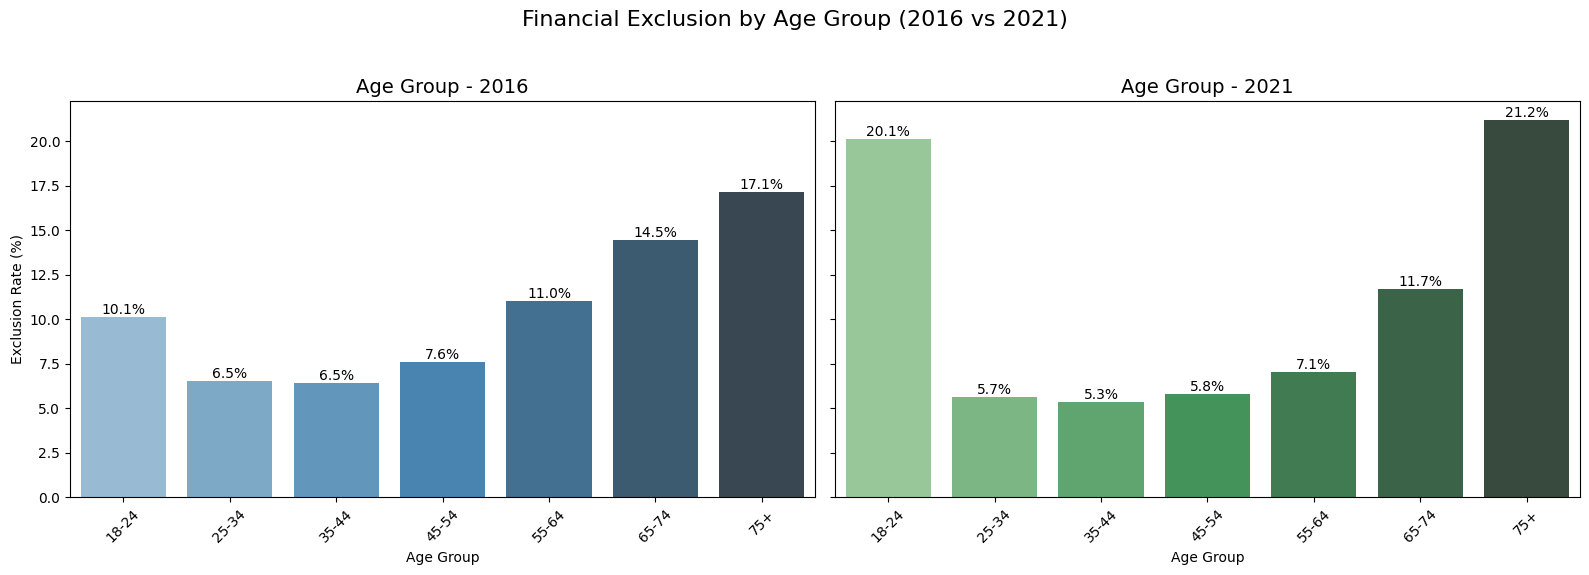

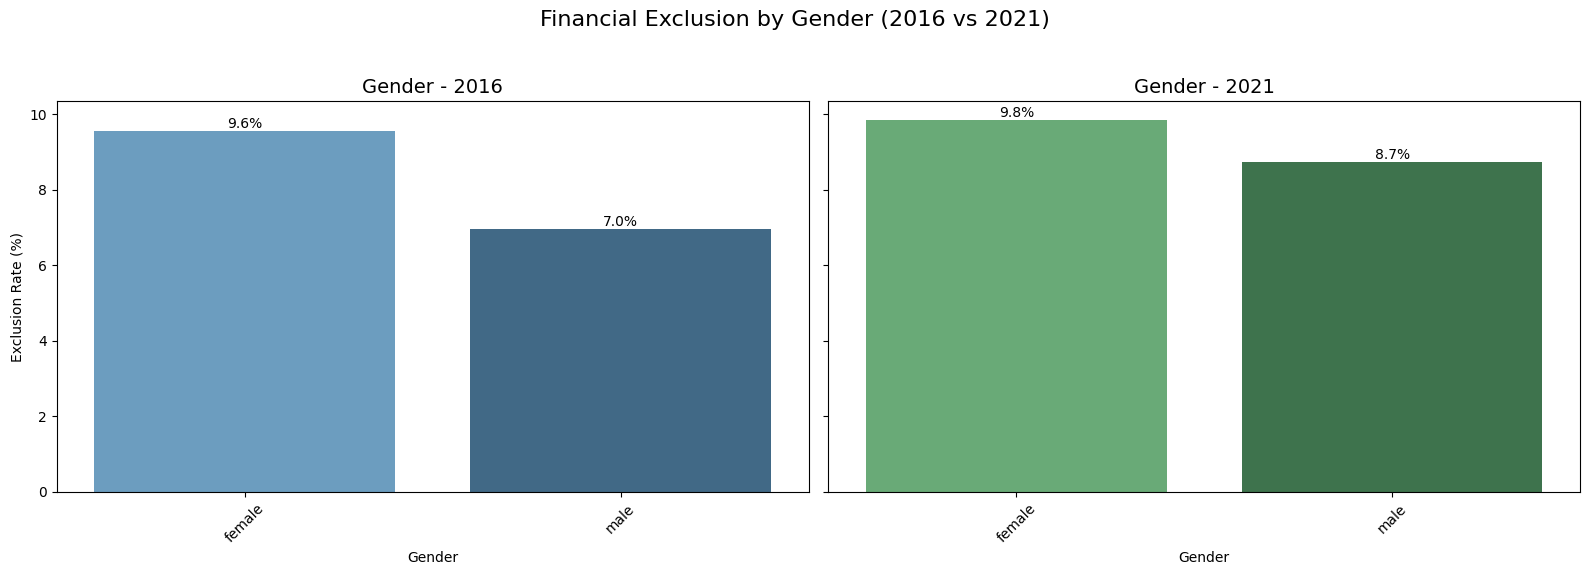

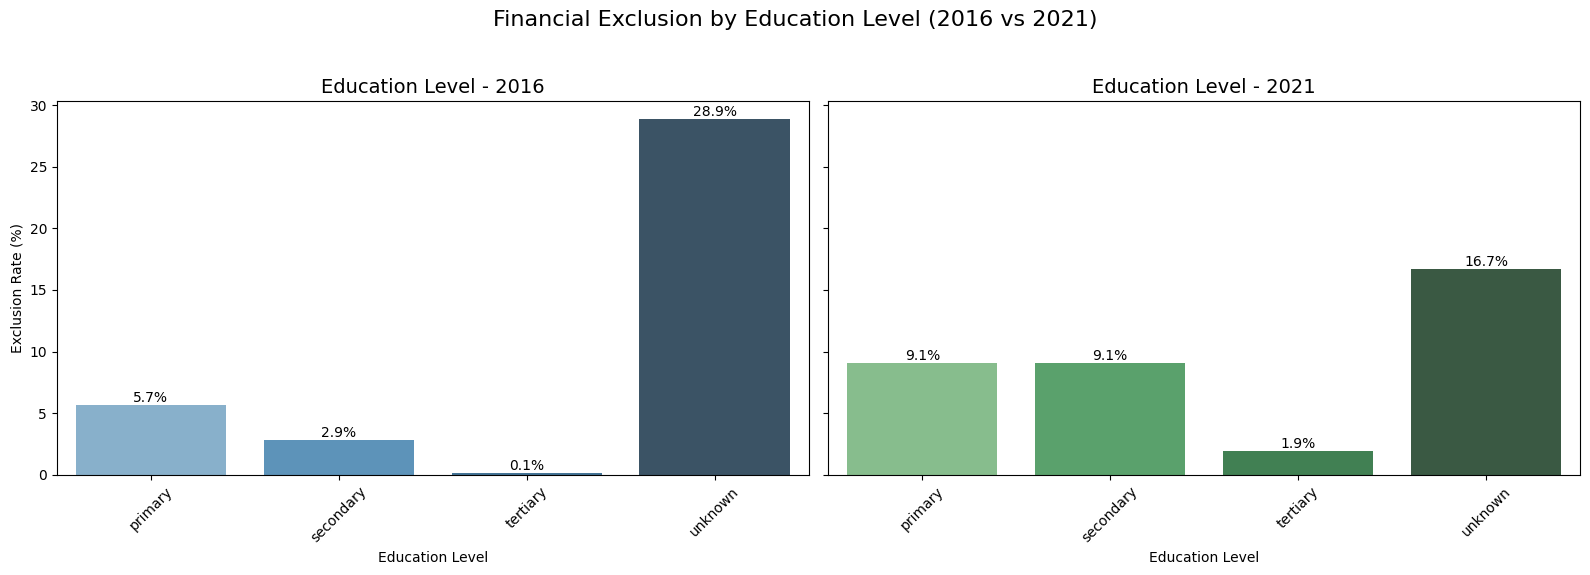

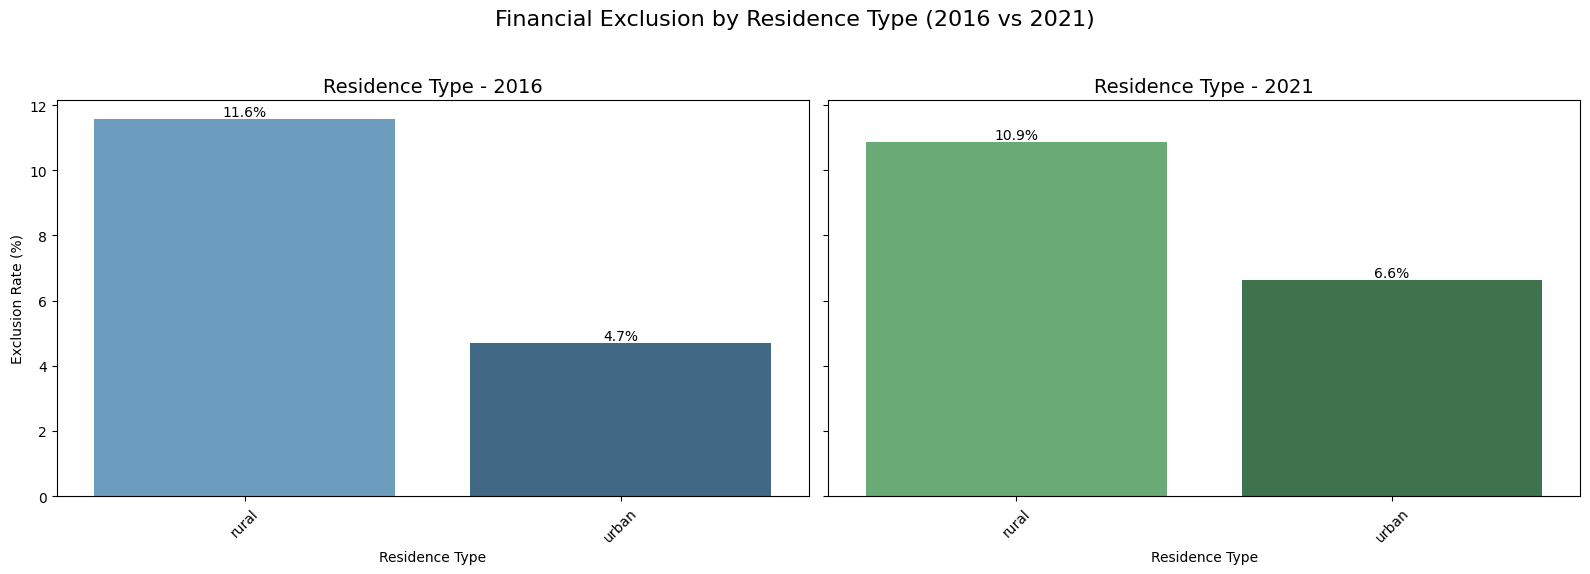

In [14]:
# First run your demographic analysis:
demo_analysis_2016 = analyze_demographic_features(df_2016_processed)
demo_analysis_2021 = analyze_demographic_features(df_2021_processed)

# Visualize clearly side-by-side comparisons
for feature in ['age_group', 'gender', 'education_level', 'residence_type']:
    visualize_demographic_comparison(demo_analysis_2016, demo_analysis_2021, feature)


In [15]:
def analyze_exclusion_by_behaviors(df):
    behavior_cols = [
        'financial_product_diversity',
        'formal_financial_score',
        'informal_financial_score',
        'digital_financial_score',
        'financial_engagement_score',
        'product_category_diversity',
        'risk_management_score'
    ]

    results = {}
    for col in behavior_cols:
        excluded_mean = df[df['financially_excluded'] == 1][col].mean()
        included_mean = df[df['financially_excluded'] == 0][col].mean()
        results[col] = {
            'excluded_mean': excluded_mean,
            'included_mean': included_mean,
            'difference': included_mean - excluded_mean,
            'ratio': included_mean / excluded_mean if excluded_mean > 0 else np.inf
        }

    cat_results = {}
    for col in ['formal_informal_ratio', 'credit_to_savings_ratio']:
        cat_counts = pd.crosstab(df[col], df['financially_excluded'], normalize='columns') * 100
        cat_results[col] = cat_counts.round(2)

    return results, cat_results


In [16]:
behavior_results_2016, cat_results_2016 = analyze_exclusion_by_behaviors(df_2016_processed)
behavior_results_2021, cat_results_2021 = analyze_exclusion_by_behaviors(df_2021_processed)


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_behavioral_comparison(res2016, res2021):
    behavior_metrics = res2016.keys()
    df_plot = pd.DataFrame({
        'Behavior Metric': behavior_metrics,
        'Included (2016)': [res2016[b]['included_mean'] for b in behavior_metrics],
        'Excluded (2016)': [res2016[b]['excluded_mean'] for b in behavior_metrics],
        'Included (2021)': [res2021[b]['included_mean'] for b in behavior_metrics],
        'Excluded (2021)': [res2021[b]['excluded_mean'] for b in behavior_metrics],
    })

    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    # 2016 data
    df_plot_melted_2016 = df_plot.melt('Behavior Metric', ['Included (2016)', 'Excluded (2016)'],
                                       var_name='Status', value_name='Mean Score')
    sns.barplot(x='Mean Score', y='Behavior Metric', hue='Status', data=df_plot_melted_2016,
                ax=axes[0], palette='Blues_d')

    axes[0].set_title('Behavioral Scores by Exclusion Status (2016)', fontsize=14)
    for p in axes[0].patches:
        width = p.get_width()
        axes[0].text(width, p.get_y() + p.get_height()/2, f'{width:.2f}', ha='left', va='center')

    # 2021 data
    df_plot_melted_2021 = df_plot.melt('Behavior Metric', ['Included (2021)', 'Excluded (2021)'],
                                       var_name='Status', value_name='Mean Score')
    sns.barplot(x='Mean Score', y='Behavior Metric', hue='Status', data=df_plot_melted_2021,
                ax=axes[1], palette='Greens_d')

    axes[1].set_title('Behavioral Scores by Exclusion Status (2021)', fontsize=14)
    for p in axes[1].patches:
        width = p.get_width()
        axes[1].text(width, p.get_y() + p.get_height()/2, f'{width:.2f}', ha='left', va='center')

    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')

    plt.suptitle('Comparison of Behavioral Scores by Financial Exclusion (2016 vs 2021)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


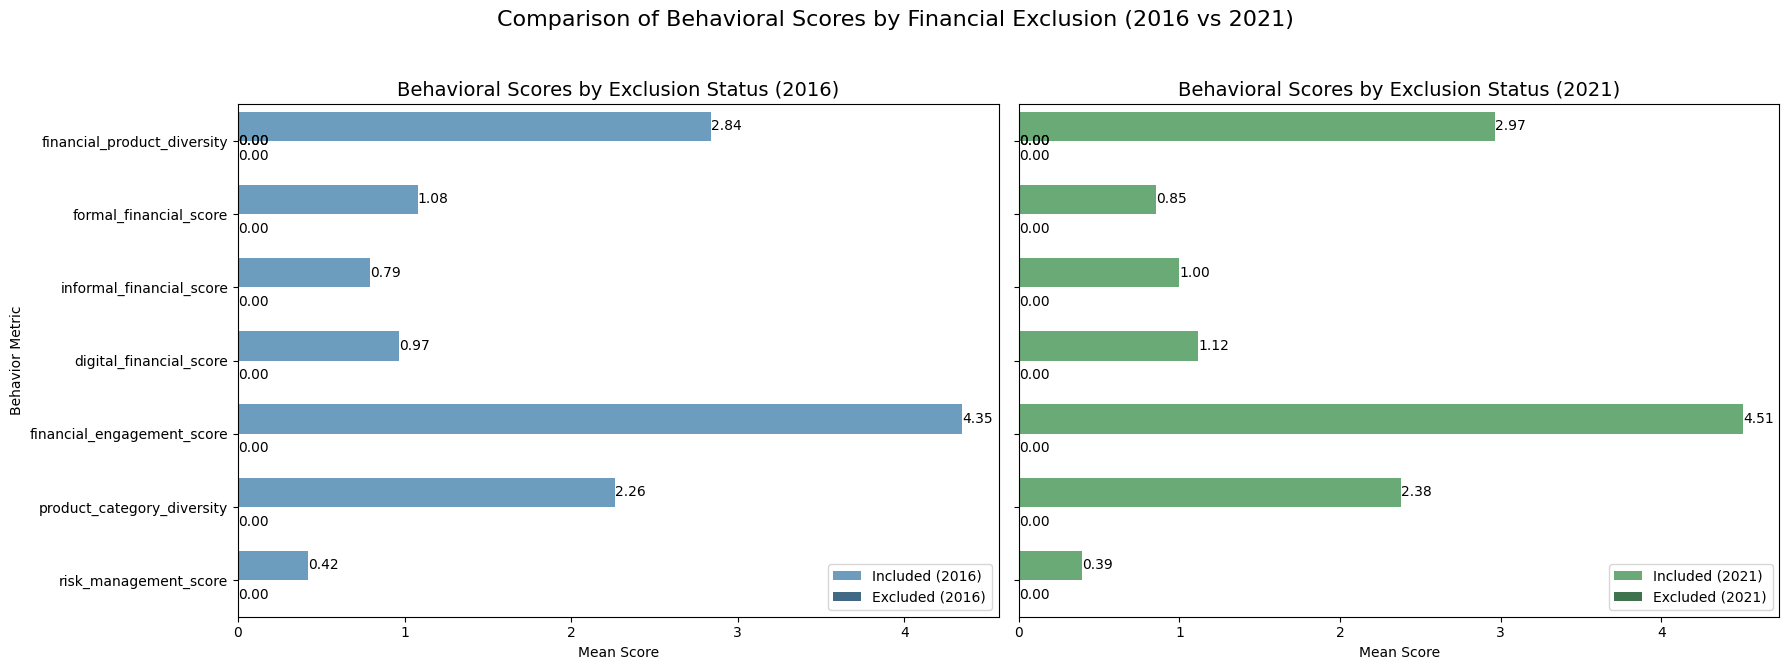

In [18]:
plot_behavioral_comparison(behavior_results_2016, behavior_results_2021)


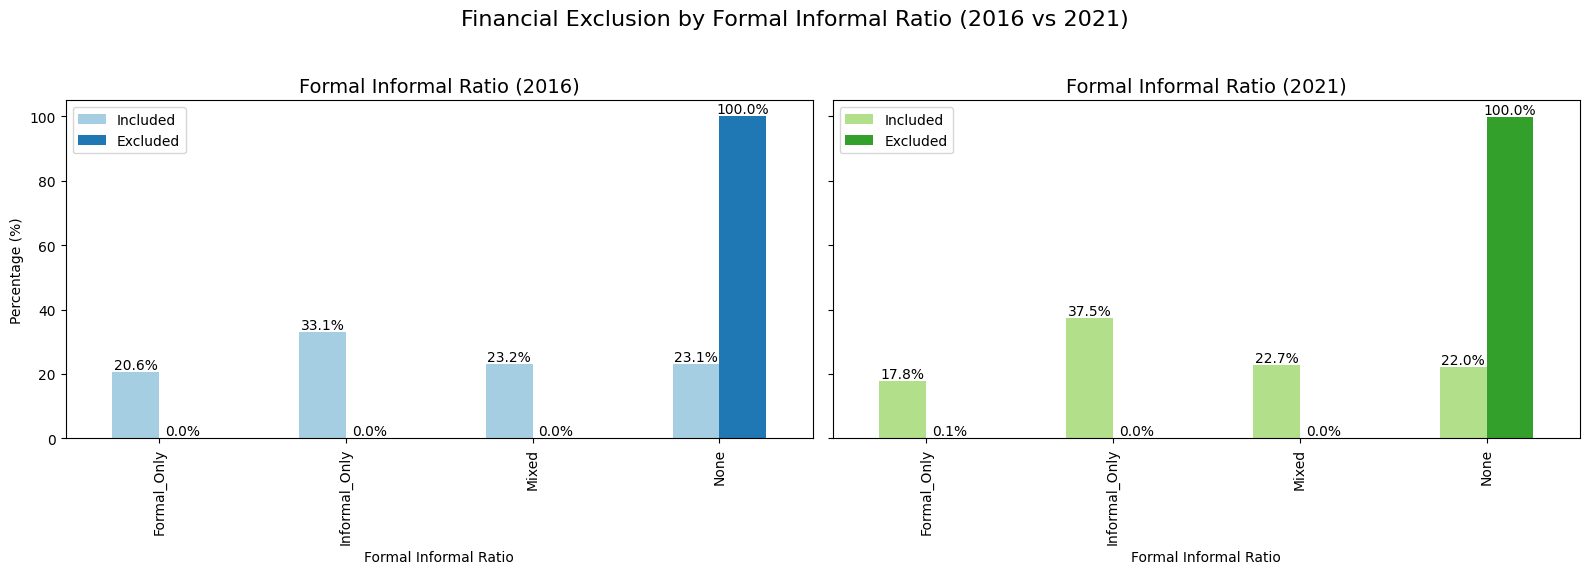

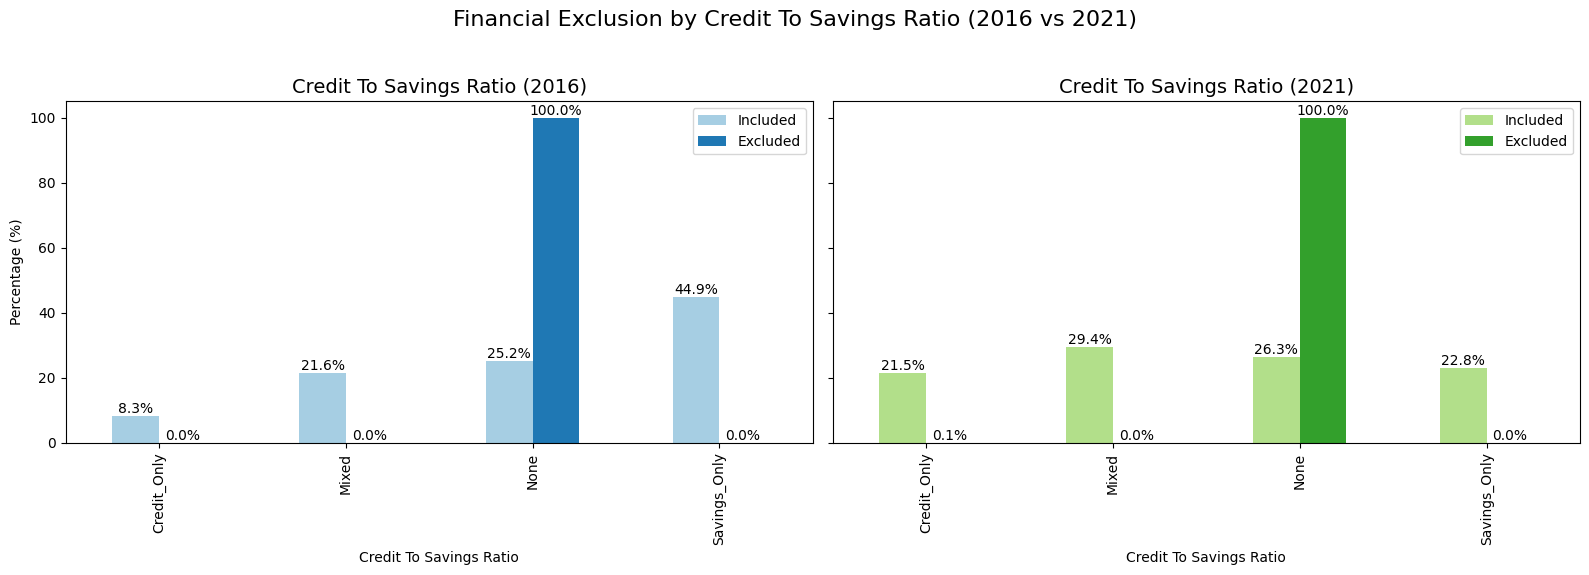

In [19]:
def plot_categorical_behavior(cat_2016, cat_2021, feature):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    cat_2016[feature].plot(kind='bar', ax=axes[0], color=['#a6cee3','#1f78b4'])
    cat_2021[feature].plot(kind='bar', ax=axes[1], color=['#b2df8a','#33a02c'])

    axes[0].set_title(f'{feature.replace("_"," ").title()} (2016)', fontsize=14)
    axes[1].set_title(f'{feature.replace("_"," ").title()} (2021)', fontsize=14)

    for ax in axes:
        ax.set_ylabel('Percentage (%)')
        ax.set_xlabel(feature.replace("_"," ").title())
        ax.legend(['Included', 'Excluded'])

        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.1f}%',
                        (p.get_x() + p.get_width() / 2, height),
                        ha='center', va='bottom')

    plt.suptitle(f'Financial Exclusion by {feature.replace("_"," ").title()} (2016 vs 2021)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Generate clearly annotated plots for both categorical behaviors:
for feature in ['formal_informal_ratio', 'credit_to_savings_ratio']:
    plot_categorical_behavior(cat_results_2016, cat_results_2021, feature)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=500),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)[:, 1]
        report = classification_report(y_test, preds, output_dict=True)
        auc = roc_auc_score(y_test, proba)

        results[name] = {
            'model': model,
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1_score': report['1']['f1-score'],
            'roc_auc': auc
        }

    return results


In [21]:
# Encode categorical vars for model
df_all = pd.concat([df_2016_processed.assign(dataset='train'), df_2021_processed.assign(dataset='test')])
df_all = pd.get_dummies(df_all, columns=[
    'gender', 'education_level', 'residence_type',
    'marital_status', 'relationship_to_hh', 'region',
    'formal_informal_ratio', 'credit_to_savings_ratio'
])

# Split back into train/test sets
train_df = df_all[df_all['dataset'] == 'train'].drop(columns=['dataset'])
test_df = df_all[df_all['dataset'] == 'test'].drop(columns=['dataset'])

X_train = train_df.drop(columns=['financially_excluded'])
y_train = train_df['financially_excluded']
X_test = test_df.drop(columns=['financially_excluded'])
y_test = test_df['financially_excluded']


In [22]:
model_results = train_and_evaluate_models(X_train, y_train, X_test, y_test)

# Convert to DataFrame
metrics_df = pd.DataFrame(model_results).T[['precision', 'recall', 'f1_score', 'roc_auc']].round(3)
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={'index': 'Model'}, inplace=True)

metrics_df


,Model,precision,recall,f1_score,roc_auc
0,Logistic Regression,0.995582,0.344371,0.511734,0.999606
1,Decision Tree,0.991895,0.498726,0.663729,0.749152
2,Random Forest,0.993562,0.471727,0.639724,0.998945
3,Gradient Boosting,0.992616,0.479368,0.646513,0.999205


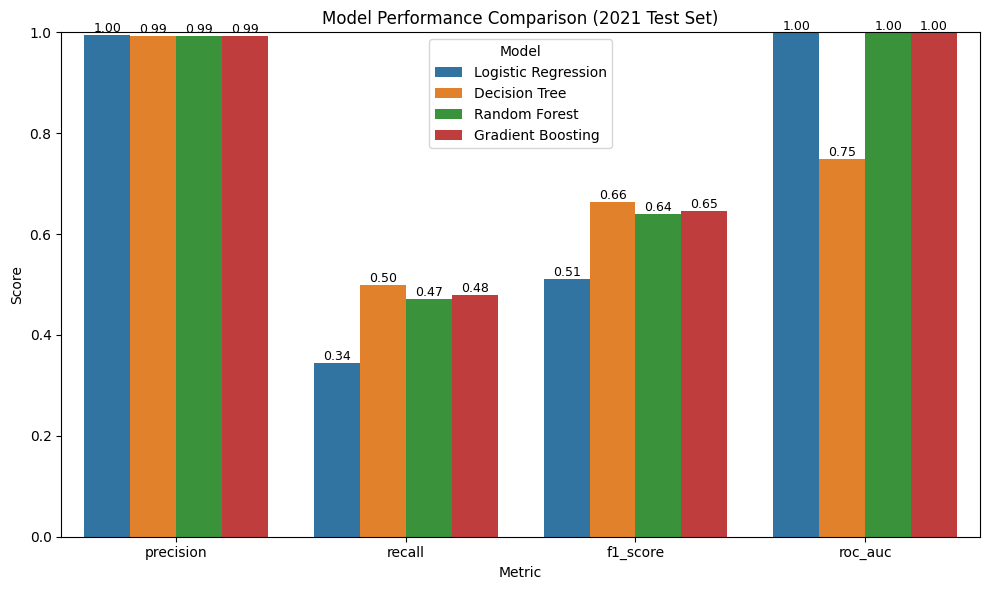

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars='Model', var_name='Metric'),
            x='Metric', y='value', hue='Model')

plt.title('Model Performance Comparison (2021 Test Set)')
plt.ylabel('Score')
plt.ylim(0, 1)
for container in plt.gca().containers:
    for bar in container:
        height = bar.get_height()
        plt.gca().annotate(f'{height:.2f}', (bar.get_x() + bar.get_width() / 2, height),
                           ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


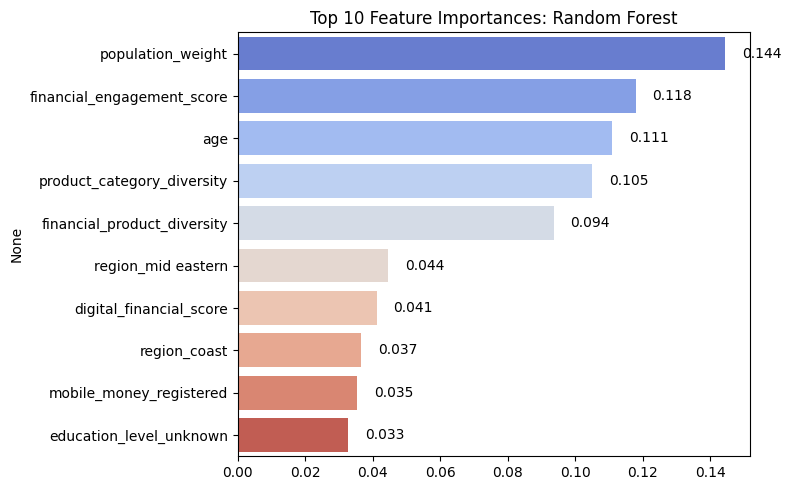

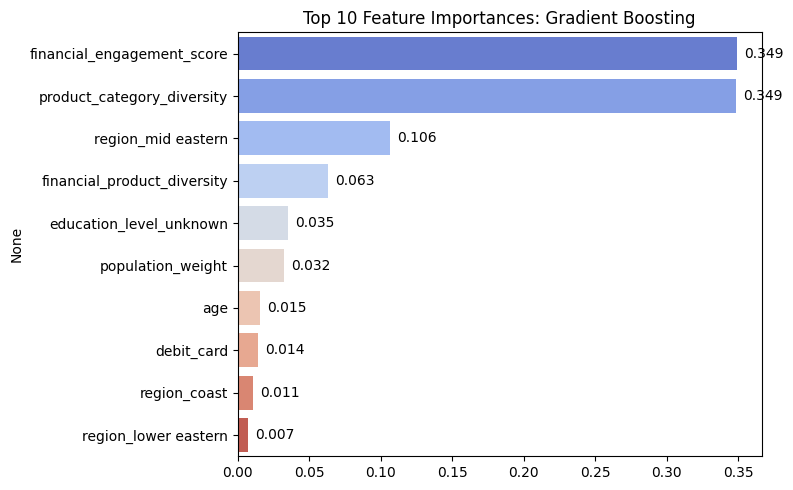

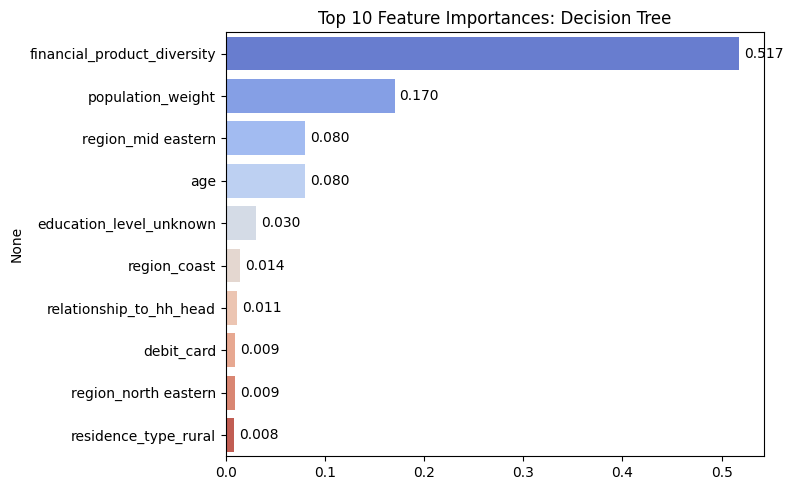

In [24]:
def plot_feature_importance(model, feature_names, title):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False).head(10)
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importance.values, y=importance.index, palette='coolwarm')
    plt.title(f'Top 10 Feature Importances: {title}')
    for i, v in enumerate(importance.values):
        plt.text(v + 0.005, i, f'{v:.3f}', color='black', va='center')
    plt.tight_layout()
    plt.show()

# Plot for each tree-based model
plot_feature_importance(model_results['Random Forest']['model'], X_train.columns, 'Random Forest')
plot_feature_importance(model_results['Gradient Boosting']['model'], X_train.columns, 'Gradient Boosting')
plot_feature_importance(model_results['Decision Tree']['model'], X_train.columns, 'Decision Tree')


In [25]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_sm).value_counts().to_dict())


Before SMOTE: {0: 7507, 1: 701}
After SMOTE: {0: 7507, 1: 7507}


In [26]:
# Train the same models on SMOTE data
model_results_smote = train_and_evaluate_models(X_train_sm, y_train_sm, X_test, y_test)

# Convert to DataFrame
metrics_df_smote = pd.DataFrame(model_results_smote).T[['precision', 'recall', 'f1_score', 'roc_auc']].round(3)
metrics_df_smote.reset_index(inplace=True)
metrics_df_smote.rename(columns={'index': 'Model'}, inplace=True)

metrics_df_smote


,Model,precision,recall,f1_score,roc_auc
0,Logistic Regression,0.99564,0.348956,0.516786,0.999097
1,Decision Tree,0.996387,0.561895,0.718567,0.780842
2,Random Forest,0.99359,0.473765,0.641601,0.997809
3,Gradient Boosting,0.997389,0.3892,0.559912,0.997492


In [27]:
comparison_df = metrics_df.merge(metrics_df_smote, on='Model', suffixes=('_baseline', '_smote'))
comparison_df


,Model,precision_baseline,recall_baseline,f1_score_baseline,roc_auc_baseline,precision_smote,recall_smote,f1_score_smote,roc_auc_smote
0,Logistic Regression,0.995582,0.344371,0.511734,0.999606,0.99564,0.348956,0.516786,0.999097
1,Decision Tree,0.991895,0.498726,0.663729,0.749152,0.996387,0.561895,0.718567,0.780842
2,Random Forest,0.993562,0.471727,0.639724,0.998945,0.99359,0.473765,0.641601,0.997809
3,Gradient Boosting,0.992616,0.479368,0.646513,0.999205,0.997389,0.3892,0.559912,0.997492


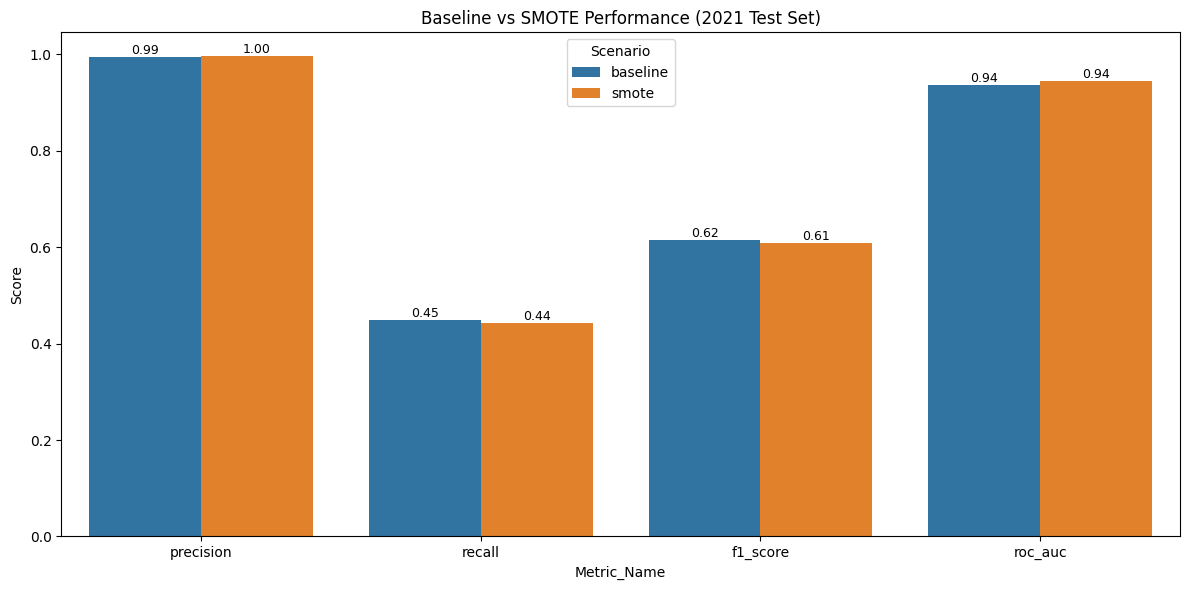

In [28]:
melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
melted[['Metric_Name', 'Scenario']] = melted['Metric'].str.extract(r'(.*)_(baseline|smote)')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Metric_Name', y='Score', hue='Scenario', ci=None)

# Annotate bars
for container in plt.gca().containers:
    for bar in container:
        height = bar.get_height()
        plt.gca().annotate(f'{height:.2f}',
                           (bar.get_x() + bar.get_width() / 2, height),
                           ha='center', va='bottom', fontsize=9)

plt.title('Baseline vs SMOTE Performance (2021 Test Set)')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


In [29]:
from sklearn.feature_selection import SelectFromModel

# Use Random Forest to find most important features
rf = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)
selector = SelectFromModel(rf, threshold="median")  # Keep top 50% important features

X_train_sel = selector.transform(X_train_sm)
X_test_sel = selector.transform(X_test)

# Re-train models with selected features
dt = DecisionTreeClassifier(random_state=42).fit(X_train_sel, y_train_sm)
rf2 = RandomForestClassifier(random_state=42).fit(X_train_sel, y_train_sm)

from sklearn.metrics import f1_score
print("Decision Tree (FS) F1:", f1_score(y_test, dt.predict(X_test_sel)))
print("Random Forest (FS) F1:", f1_score(y_test, rf2.predict(X_test_sel)))


Decision Tree (FS) F1: 0.7356247992290396
Random Forest (FS) F1: 0.6515930113052415


In [30]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
], voting='soft')

voting_model.fit(X_train_sm, y_train_sm)
f1_score(y_test, voting_model.predict(X_test))


0.7185667752442997

In [31]:
from sklearn.feature_selection import SelectFromModel

# Use Random Forest to identify most important features
rf_base = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)
selector = SelectFromModel(rf_base, threshold="median")  # Keep top 50% of features

X_train_sel = selector.transform(X_train_sm)
X_test_sel = selector.transform(X_test)


In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

dt_params = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=dt_params, scoring='f1', cv=3, n_jobs=-1)
dt_grid.fit(X_train_sel, y_train_sm)

best_dt = dt_grid.best_estimator_
dt_f1 = f1_score(y_test, best_dt.predict(X_test_sel))
print("Best Decision Tree F1 Score:", dt_f1)


Best Decision Tree F1 Score: 0.925845147219193


In [33]:
rf_params = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid=rf_params, scoring='f1', cv=3, n_jobs=-1)
rf_grid.fit(X_train_sel, y_train_sm)

best_rf = rf_grid.best_estimator_
rf_f1 = f1_score(y_test, best_rf.predict(X_test_sel))
print("Best Random Forest F1 Score:", rf_f1)


Best Random Forest F1 Score: 0.6727334007414897


In [34]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[
    ('dt', best_dt),
    ('rf', best_rf)
], voting='soft')

voting_model.fit(X_train_sel, y_train_sm)
voting_f1 = f1_score(y_test, voting_model.predict(X_test_sel))
print("Voting Ensemble F1 Score:", voting_f1)


Voting Ensemble F1 Score: 0.9055555555555556


In [35]:
improved_models = pd.DataFrame({
    'Model': ['Optimized Decision Tree', 'Optimized Random Forest', 'Voting Ensemble'],
    'F1 Score': [dt_f1, rf_f1, voting_f1]
}).round(3)

improved_models


,Model,F1 Score
0,Optimized Decision Tree,0.926
1,Optimized Random Forest,0.673
2,Voting Ensemble,0.906


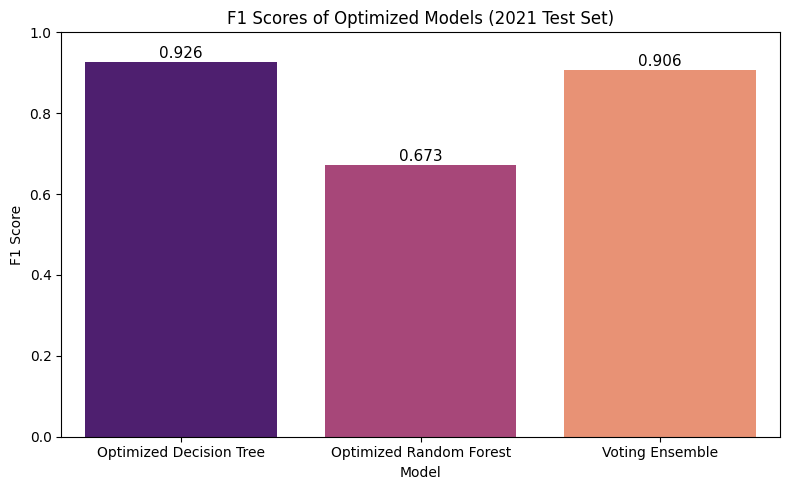

In [36]:
plt.figure(figsize=(8, 5))
sns.barplot(data=improved_models, x='Model', y='F1 Score', palette='magma')

for i, row in improved_models.iterrows():
    plt.text(i, row['F1 Score'] + 0.01, f"{row['F1 Score']:.3f}", ha='center', fontsize=11)

plt.ylim(0, 1)
plt.title('F1 Scores of Optimized Models (2021 Test Set)')
plt.tight_layout()
plt.show()


In [37]:
import joblib

# Save the trained models
joblib.dump(best_dt, 'decision_tree_model.pkl')
joblib.dump(voting_model, 'voting_ensemble_model.pkl')

# Save the feature selector (SelectFromModel object)
joblib.dump(selector, 'feature_selector.pkl')

# Save the actual feature names used before selection
original_feature_names = X_train_sm.columns
selected_features = original_feature_names[selector.get_support()]
joblib.dump(selected_features.tolist(), 'selected_features.pkl')

print("All models and selected features saved for deployment.")


All models and selected features saved for deployment.


In [38]:
import shap

# Access individual estimators within the VotingClassifier
estimators = voting_model.estimators_

# Iterate through estimators and calculate SHAP values
shap_values_list = []
for estimator in estimators:
    if isinstance(estimator, (DecisionTreeClassifier, RandomForestClassifier)):
        # Check if estimator is tree-based
        explainer = shap.TreeExplainer(estimator)
        # Use X_train_sel for SHAP values calculation to match the training data shape
        shap_values = explainer.shap_values(X_train_sel)
        shap_values_list.append(shap_values)

# Example: Plot SHAP values for the first tree-based estimator
# (Adjust index if needed)
# Use X_train_sel for plotting as well, and specify the correct index for shap_values
shap.summary_plot(shap_values_list[0], X_train_sel,  # This line is changed
                  feature_names=X_train.columns[selector.get_support()])

# Further analysis or combination of SHAP values can be done
# based on your specific requirements.

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [ ]:
import lime
import lime.lime_tabular
import numpy as np

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_sel),
    feature_names=X_train.columns[selector.get_support()],
    class_names=['Included', 'Excluded'],
    mode='classification'
)

# Pick one instance to explain
instance = X_test_sel[0].reshape(1, -1)
lime_exp = lime_explainer.explain_instance(instance.flatten(), voting_model.predict_proba)

# View in notebook
print(lime_exp.as_list())
with open("lime_explanation.html", "w") as f:
    f.write(lime_exp.as_html())


NB: The below is to guide you in deployng the work

In [ ]:
lime_exp.show_in_notebook(show_table=True)


PREPARE NEW DATA BEFORE PREDICTION PIPELINE

In [ ]:
import numpy as np
import pandas as pd

def preprocess_new_data(df_raw, feature_selector=None):
    # === 1. Binary Encode Yes/No columns ===
    def binary_encode(df):
        for col in df.columns:
            if df[col].dtype == 'object' and set(df[col].dropna().unique()).issubset({'Yes', 'No', 'yes', 'no', ' ', '', None, np.nan}):
                df[col] = df[col].map({
                    'Yes': 1, 'yes': 1,
                    'No': 0, 'no': 0,
                    ' ': 0, '': 0,
                    None: 0, np.nan: 0
                })
        return df.fillna(0)

    df = binary_encode(df_raw.copy())

    # === 2. Feature Groups (same as before) ===
    feature_groups = {
    'formal_savings': [
        'bank_account_current', 'bank_account_savings', 'bank_account_everyday',
        'postbank_account', 'savings_microfinance', 'savings_sacco'
    ],
    'informal_savings': [
        'savings_group_friends', 'savings_family_friend', 'savings_secret_place'
    ],
    'digital_financial': [
        'mobile_money_registered', 'mobile_banking_registered', 'savings_mobile_banking',
        'loan_mobile_banking', 'loan_digital_app'
    ],
    'formal_credit': [
        'loan_bank', 'loan_sacco', 'loan_microfinance', 'loan_govt',
        'loan_employer', 'loan_mortgage'
    ],
    'informal_credit': [
        'loan_shylock', 'loan_group_chama', 'loan_family_friend',
        'loan_shopkeeper_cash', 'loan_goods_credit'
    ],
    'insurance': [
        'insurance_motor', 'insurance_home', 'insurance_crop', 'insurance_livestock',
        'insurance_nhif', 'insurance_health_other', 'insurance_life', 'insurance_education',
        'insurance_other'
    ],
    'pension': [
        'pension_nssf', 'pension_mbao', 'pension_other'
    ]
  }

    # === 3. Score Computation ===
    for group_name, columns in feature_groups.items():
        df[f'{group_name}_score'] = df[[c for c in columns if c in df.columns]].sum(axis=1)

    df['formal_financial_score'] = df[[f for f in (
        feature_groups['formal_savings'] + feature_groups['formal_credit'] + feature_groups['insurance'] + feature_groups['pension']
    ) if f in df.columns]].sum(axis=1)

    df['informal_financial_score'] = df[[f for f in (
        feature_groups['informal_savings'] + feature_groups['informal_credit']
    ) if f in df.columns]].sum(axis=1)

    df['financial_engagement_score'] = (
        1.5 * df['formal_financial_score'] +
        1.0 * df['informal_financial_score'] +
        2.0 * df['digital_financial_score']
    )

    df['product_category_diversity'] = df[[f"{g}_score" for g in feature_groups]].gt(0).sum(axis=1)
    df['risk_management_score'] = df[[f for f in (feature_groups['insurance'] + feature_groups['pension']) if f in df.columns]].sum(axis=1)

    df['formal_informal_ratio'] = np.where(
        df['informal_financial_score'] == 0,
        np.where(df['formal_financial_score'] > 0, 'Formal_Only', 'None'),
        np.where(df['formal_financial_score'] == 0, 'Informal_Only', 'Mixed')
    )

    df['credit_to_savings_ratio'] = np.where(
        (df['formal_savings_score'] + df['informal_savings_score']) == 0,
        np.where((df['formal_credit_score'] + df['informal_credit_score']) > 0, 'Credit_Only', 'None'),
        np.where((df['formal_credit_score'] + df['informal_credit_score']) == 0, 'Savings_Only', 'Mixed')
    )

    # === 4. Demographics ===
    if 'age' in df.columns:
        df['age'] = pd.to_numeric(df['age'], errors='coerce').fillna(df['age'].median())

    # === 5. One-hot encode ===
    categorical = ['gender', 'education_level', 'residence_type', 'marital_status', 'relationship_to_hh', 'region', 'formal_informal_ratio', 'credit_to_savings_ratio']
    df_encoded = pd.get_dummies(df, columns=[c for c in categorical if c in df.columns], drop_first=False)

    # === 6. Feature Selection ===
    if feature_selector:
        df_final = feature_selector.transform(df_encoded)
    else:
        df_final = df_encoded  # for training/debug

    return df_final
